In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

import os

from datetime import date

from statistics import mean

import functions as fun

pd.options.display.max_colwidth = 400 #we used this in the NLP EDA Lab 5.02 and it I thought it makes sense to use it here, too.

In [64]:
df = pd.read_csv('data/data2022-06-26.csv')

In [65]:
df.head(1)

,created_utc,selftext,subreddit,title
0,1656261965,[removed],startrek,Which version of Klingons will appear in SNW?


In [66]:
df.dtypes

created_utc     int64
selftext       object
subreddit      object
title          object
dtype: object

In [67]:
df.isnull().sum()

created_utc       0
selftext       2359
subreddit         0
title             0
dtype: int64

In [68]:
df.shape

(6946, 4)

# Building New DataFrame
I opted to fill the nulls with '' in order to explore posts that just consist of the title, which seems to be a fairly common way to use these subreddits.

Otherwise, to streamline this notebook, I came back to this point after EDA/modeling and made all changes I want so I could work from the one dataframe. I think almost all the changes are pretty self-explanatory. Two I'd like to note: 
* I turned the column name 'subreddit' into 'subreddit_name' because I found after vectorizing that, unsurprisingly, the word 'subreddit' appeared in the words that were vectorized, leading to the need for a name change in the column when I concatenated the vectorization with the 'subreddit'(name) column. 
* I created the 'all_words' column, combining the 'title' and the 'selftext' because I found a high percentage of the /r/StarWars posts (just over half of them), had no 'selftext'. In other words, a high percentage of the written communication happening in that subreddit, in particular, is happening in the titles. For that reason, I wanted to include both the titles and the 'selftext' (text from the post body) in my analysis.

NOTE 1: I could also do the same with 'title' (to 'title_text') and 'selftext' (to 'self_text') to protect against the chance that either of these appear in the vectorization ('title' presumably does, somewhere), but given that I didn't use either of those columns in a concatenation, I'm not doing so now since it would require rewriting a *lot* of code to account for the title change.

NOTE 2: I referenced the NLP EDA Lab 5.02 when writing the code to add column and word counts.

NOTE 3: I call mean_word_length from my functions file. For this function, this [stackoverflow answer](https://stackoverflow.com/a/59911989) helped with finding mean and [this one](https://stackoverflow.com/a/29350747) helped with eliminating the characters that weren't letters.

In [23]:
df['selftext'] = df['selftext'].fillna('')
print(df.isnull().sum())
df['subreddit'] = df['subreddit'].str.lower()
for i in range(len(df)):
    if df.loc[i, 'selftext'] == '[removed]' or df.loc[i,'selftext'] == '[deleted]':
        df.loc[i, 'all_words'] = df.loc[i, 'title']
    else:
        df.loc[i, 'all_words'] = df.loc[i, 'title']+df.loc[i, 'selftext']
    df.loc[i, 'submission_length'] = len(df.loc[i, 'selftext'])
    df.loc[i, 'title_length'] = len(df.loc[i, 'title'])
    df.loc[i, 'submission_word_count'] = len(df.loc[i,'selftext'].split())
    df.loc[i, 'title_word_count'] = len(df.loc[i,'title'].split())
    if df.loc[i, 'selftext'] == '':
        df.loc[i, 'no_selftext'] = 1
    else:
        df.loc[i, 'no_selftext'] = 0

df['avg_word_length'] = df['all_words'].map(fun.mean_word_length)
df = df.rename(columns = {'subreddit': 'subreddit_name'})

df.head()

created_utc    0
selftext       0
subreddit      0
title          0
dtype: int64


,created_utc,selftext,subreddit_name,title,all_words,submission_length,title_length,submission_word_count,title_word_count,no_selftext,avg_word_length
0,1656261965,[removed],startrek,Which version of Klingons will appear in SNW?,Which version of Klingons will appear in SNW?,9.0,45.0,1.0,8.0,0.0,4.625000
1,1656254308,[removed],startrek,On the Gorn and language,On the Gorn and language,9.0,24.0,1.0,5.0,0.0,4.000000
2,1656248567,[removed],startrek,What are some good things that can be said about Star Trek V?,What are some good things that can be said about Star Trek V?,9.0,61.0,1.0,13.0,0.0,3.692308
3,1656238740,[removed],startrek,A Lord of the Rings reference in SNW 1x08,A Lord of the Rings reference in SNW 1x08,9.0,41.0,1.0,9.0,0.0,3.333333
4,1656238132,[removed],startrek,The sword props used in SNW 1x08 are replicas of Aragorn's sword from 'The Fellowship of the Ring' and 'The Two Towers',The sword props used in SNW 1x08 are replicas of Aragorn's sword from 'The Fellowship of the Ring' and 'The Two Towers',9.0,119.0,1.0,22.0,0.0,4.090909


In [24]:
df[df['subreddit_name'] != 'startrek'].head(3)

,created_utc,selftext,subreddit_name,title,all_words,submission_length,title_length,submission_word_count,title_word_count,no_selftext,avg_word_length
3537,1656263202,[removed],starwars,"I know (almost) nothing about Star Wars, ask me anything","I know (almost) nothing about Star Wars, ask me anything",9.0,56.0,1.0,10.0,0.0,4.4
3538,1656263028,[removed],starwars,My Star Wars writing debut,My Star Wars writing debut,9.0,26.0,1.0,5.0,0.0,4.4
3539,1656258044,[removed],starwars,I wrote a story!,I wrote a story!,9.0,16.0,1.0,4.0,0.0,3.0


In [17]:
df.dtypes

created_utc                int64
selftext                  object
subreddit_name            object
title                     object
all_words                 object
submission_length        float64
title_length             float64
submission_word_count    float64
title_word_count         float64
no_selftext              float64
avg_word_length          float64
dtype: object

# Comparing Blank 'selftext' (Post Body) Across the Subreddits

Does either subreddit have a higher rate of blank 'selftext', or post bodies? For the purposes of this I'm removing the 'removed' and 'deleted' posts.

In [17]:
print('Value counts by subreddit:\n',df['subreddit'].value_counts())
print('')
print('Value counts of blank posts by subreddit:\n',df[df['selftext'] == '']['subreddit'].value_counts())

blank_values = df[df['selftext'] == '']['subreddit'].value_counts().tolist()
blank_keys = df[df['selftext'] == '']['subreddit'].value_counts().keys().tolist()
print('')
print('Blank Keys:', blank_keys)

sw_percent_blank = blank_values[0]/len(df[df['subreddit'] == 'starwars'])*100
st_percent_blank = blank_values[1]/len(df[df['subreddit'] == 'startrek'])*100
print(' ')
print('*'*25)
print('Star Wars percent blank submissions:', sw_percent_blank)
print('='*20)
print('Star Trek percent blank submissions:', st_percent_blank)

Value counts by subreddit:
 startrek    3537
starwars    3409
Name: subreddit, dtype: int64

Value counts of blank posts by subreddit:
 starwars    1729
startrek     630
Name: subreddit, dtype: int64

Blank Keys: ['starwars', 'startrek']
 
*************************
Star Wars percent blank submissions: 50.71868583162218
Star Trek percent blank submissions: 17.8117048346056


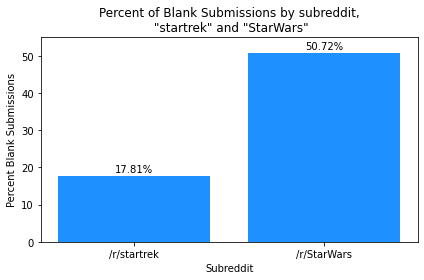

In [18]:
plt.title('Percent of Blank Submissions by subreddit,\n "startrek" and "StarWars"')
plt.xlabel('Subreddit')
plt.ylabel('Percent Blank Submissions')
plt.ylim(0,55)
plt.bar(['/r/startrek', '/r/StarWars'], [st_percent_blank, sw_percent_blank], color = 'dodgerblue')

plt.text(1, sw_percent_blank+1, str(round(sw_percent_blank, 2))+'%', ha = 'center')
plt.text(0, st_percent_blank+1, str(round(st_percent_blank, 2))+'%', ha = 'center')

plt.tight_layout()
plt.savefig('images/percent_blank_posts.png');


Because of the high percentage of blank posts, consisting just of a title, in the StarWars subreddit, I'm going to include the titles in my model building. It seems to be an important part of how StarWars subredditors communicate with each other.

# `'[removed]'`

Posts are removed from subreddits because they violate subreddit policies. Did either subreddit have a higher rate of removal? Were there any patterns in what words appeared in removed posts across both subreddits? Within each?

IMPORTANT NOTE ON METHODOLOGY: It's possible that some portion of the removed posts were removed because they were duplicates of other posts. [The rules for the StarWars subreddit](https://www.reddit.com/r/StarWars/wiki/rules) are explicit that you cannot repost material. However, as I'm exploring the language used in these posts, I opted to remove the repeat titles. Admittedly, that means that some of the titles that are analyzed may point towards posts that were removed for repetition, *not* for the content itself, but that's a possibility I decided is preferable to overcounting the words in the repeated titles. On the day that I drew my data, there were 53 repeated Star Trek titles and 83 repeated Star Wars titles. These represent a relatively small number of data points.

## Rates of Removal

Observations:

There are 3584 Star Trek posts in the data set, of which 39.29% are "[removed]"
There are 3490 Star Wars posts in the data set, of which 16.48% are "[removed]"
Star Trek posts are removed at a higher rate.

![Removal Rates Bar Chart](images/removal_rates.png "removal rates for 'startrek' and 'StarWars' subreddits")

NOTE: I referenced [this site](https://www.digitalocean.com/community/tutorials/markdown-markdown-images) and [this site](https://marinegeo.github.io/2018-08-10-adding-images-markdown/) to learn how to add images to markdown files.

**I believe, instead, that the discrepancy in rates of removal results from differences in the two subreddits rules.**

I checked [the rules for the startrek subreddit](https://www.reddit.com/r/startrek/wiki/guidelines) and [the rules for the StarWars subreddit](https://www.reddit.com/r/StarWars/wiki/rules). Interestingly, the Star Wars rules were harder to find while the Star Trek ones were posted at the top of the page.

Subjectively, the Star Trek rules seem more attuned to interpersonal relationships (the first four are 'Be constructive', 'Be welcoming', 'Be honest', and 'Be nice'). None of the overall Star Wars rules speak about interpersonal behavior, though within the rules about 'comments' there is a rule about respecting fellow redditors, which links to [this page](https://www.reddit.com/r/StarWars/comments/cq4yv9/respecting_fellow_redditors_civility_bans_and_you/). This suggests that whether or not Star Trek fans are more likely to go after a show they don't like or break rules than Star Wars fans are, the moderation rules/moderators of the 'startrek' subreddit go further in enforcing some norms than those of the 'StarWars' subreddit.

## Word Usage in Removed Post Titles Compared with Word Usage in Non-Removed Post Titles

To examine the most frequently appearing words in the titles of these posts, I vectorized them. I tried to remove only value neutral words. For example, the English stopwords list includes 'not', and it seemed plausible that negative posts may be more likely to be removed, so I wanted to be able to examine those words.

I then compared the most frequently appearing words that appeared in the removed posts to those in all of the posts to see if there were any words that appeared in the former, but not in the latter:

-----

|List|Words That Appear In All 'Removed' List But Not In 'Not Removed' List, Neutral Stopwords|
|---|---|
|Top 10| `'picard'`|
|Top 25| `'snw', 'so', 'spoilers'`|
|Top 50| `'question', 'watch', 'tng', 'time', 'enterprise', 'should', 'some', 'want', 'discovery'`|

-----

|List|Words That Appear In Star Trek 'Removed' List But Not In 'Not Removed' List, Neutral Stopwords|
|---|---|
|Top 10| `<NO WORDs>`|
|Top 25| `'has', 'time', 'can'`|
|Top 50| `'anyone', 'some', 'love', 'had', 'ever'`|

-----

|List|Words That Appear In Star Wars 'Removed' List But Not In All Posts List, Neutral Stopwords|
|---|---|
|Top 10| `'series', 'spoilers'`|
|Top 25| `'spoilers', 'should', 'show', 'finale', 'watch', 'but'`|
|Top 50| `'should', 'watch', 'order', 'question', 'reva', 'ep', 'want', 'best', 'season', 'sith', 'never', 'no'`|

-----

The only 'negative' word that appeared is 'no', the last word in the Star Wars 'Removed' versus 'Not Removed' top 50 list.

I found the appearance of Star Trek titles ("Picard", "Enterprise", and "Discovery"), potentially interesting. Were Star Trek fans flaming these shows and getting removed for doing so in a way that was in violation of the subreddit's moderator policies? Instead, it appears that this was simply a product of the higher rate at which Star Trek shows are removed. No titles appear in the Star Trek exclusive comparisons.

The Star Wars discrepancies were a little more interesting:

Firstly, the appearance of 'spoilers' among the words appearing more frequently in removed posts than all posts at both the Top 10 and Top 25 level suggests that posting about "spoilers" leads to more frequent removal. It's also interesting that [Reva](https://starwars.fandom.com/wiki/Reva), a specific character appears in these lists,  as does ['Sith'](https://starwars.fandom.com/wiki/Sith?so=search), a group of characters, whereas there are no characters in the Star Trek list. This *might* suggest that Star Wars fans are more likely to discuss specific characters in a way that gets them removed. That said, these are both references that are relevant to a new show (['Obi-Wan Kenobi'](https://en.wikipedia.org/wiki/Obi-Wan_Kenobi_(TV_series), with Reva being a character on the show, it seems plausible that they're simply being discussed more frequently in posts that include spoilers and are being removed for their spoilers, not because of inflammatory discussion of characters.

I wanted to see what happened when I used the 'english' stopwords list. The results here provided more interesting details.

-----

|List|Words That Appear In All 'Removed' List But Not In 'Not Removed' List, 'english' Stopwords|
|---|---|
|Top 10| `'strange', 'worlds'`|
|Top 25| `'question', 'watch', 'tng', 'time', 'enterprise'`|
|Top 50| `'want', 'character', 'ds9', 'voyager', 'tos', 'order', 'st', 'borg', 'thoughts', 'help', 'episodes', 'make'`|

-----

|List|Words That Appear In Star Trek 'Removed' List But Not In 'Not Removed' List, 'english' Stopwords|
|---|---|
|Top 10| `<NO WORDs>`|
|Top 25| `'question', 'voyager', 'watch'`|
|Top 50| `'character', 'want', 'good', 'characters', 'favorite', 'people', 'crew', 'help', 'timeline', 'make', 'better', 'future', 'canon'`|

-----

|List|Words That Appear In Star Wars 'Removed' List But Not In 'Not Removed' Posts List, 'english' Stopwords|
|---|---|
|Top 10| `'series', 'spoilers'`|
|Top 25| `'watch', 'order', 'question', 'reva', 'ep', 'want'`|
|Top 50| `'ep', 'want', 'sith', 'hate', 'starwars', 'thoughts', 'didn', 'start', 'fan', 'seen', 'discussion'`|

-----

There seem to be similar patterns in the appearance of Star Trek proper names in the 'All Removed Posts' lists, appearing to correlate to the higher rate of removal on /r/startrek. 

As a Star Trek fan, it's interesting to see the appearance of 'canon' in the removed posts within the Star Trek analysis. Recent shows have, in the minds of many fans, deviated from 'canon', and some fans have been quite upset by it. It seems plausible that posts about 'canon' may be complaints about violations of 'canon' that have crossed a line into violations of the moderation policies. I find the top 50 word list as awhole very interesting: this is admittedly subjective, but the words seem to reflect poster's desires and a lot of discussion of characters/people. The order of the list in two cases, 'want' 'good' 'characters' and 'make' 'better' is perhaps ironic. Could it be that people are reflecting these desires in ways that are violating the rules for the subreddit?

The Star Wars words are also similar, though it's interesting to see the word 'hate' in particular showing up. Otherwise, similar patterns of words that seem plausibly related to spoilers appear.

The most notable two words in the set are 'ep' and 'want'. They are the only words that appear in successive lists across the whole analysis of these words: in other words, every other word that's in, for example, the top 25 list in any other set must appear in the top 50 of the non-removed posts, thus pushing it out of the discrepancy list when looking at all 50 words in both lists. For example, because 'order' is in the top 25 for removed Star Wars posts but not for the non-removed Star wars posts, it appears in our Top 25 list. It does not appear in the Top 50 list, however, which means that it must appear in the Top 50 list for the non-removed Star Wars posts, and thus doesn't show up as a discrepancy when looking at all 50 words from both lists.

Particularly because 'ep' is so specific, an abbreviation for 'episode', presumably, I wonder if it's possible that there's a single user or group of users who are inclined to use that abbreviation that also post things that get removed at a higher rate.

There's only one word that appears across all posts that's in both Star Trek and Star Wars: 'want'. This suggests that posts that reflect what a subredditor 'wants' is more likely to violate a subreddit policy regardless of whether it's the Star Trek or Star Wars subreddit. Is it possible that this could be true on subreddits for other entertainment properties? A potential avenue for future exploration.

I started to break the lists down to top 10, 11-25, and 26-50, but realized that would not likely be revelatory: 'discovery' ('Star Trek: Discovery') appears in the 26-50 most used words for removed posts, but not for all posts. However, it doesn't appear when comparing the top 50, which suggests that 'discovery' actually appears higher in the non-removed posts than in the removed posts.

An examination of the top 10, 25, and 50 words in all posts verifies this. These lists don't reveal any surprises, though they do provide a list to work from for removing potential 'proper name' stop words if we want to examine the language that's not proper names from either show to see what non-show-specific words appear most frequently

A possible avenue for modeling is to see it it's possible to predict which posts were removed based on the title. I don't think I'll undertake that on this project, but wanted to flag it.

[This stackoverflow answer](https://stackoverflow.com/a/48115401), which I've referenced before, helped me to understand how to pull out the keys and values from the value counts for the following work.

In [26]:
print(len(df[df['selftext'] == '[removed]']))
print('')
print(df[df['selftext'] == '[removed]']['subreddit_name'].value_counts())
print('')
values = df[df['selftext'] == '[removed]']['subreddit_name'].value_counts().keys().tolist()
counts = df[df['selftext'] == '[removed]']['subreddit_name'].value_counts().tolist()

print(f'Check that count totals are equal to thet total number of "[removed]" posts, {len(df[df["selftext"] == "[removed]"])}: {counts[0]} + {counts[1]} = {counts[0]+counts[1]}')
print('')
print(f'There are {len(df[df["subreddit_name"] == "startrek"])} Star Trek posts in the data set, of which {round((counts[0]/len(df[df["subreddit_name"] == "startrek"]))*100, 2)}% are "[removed]"')
print(f'There are {len(df[df["subreddit_name"] == "starwars"])} Star Wars posts in the data set, of which {round((counts[1]/len(df[df["subreddit_name"] == "starwars"]))*100, 2)}% are "[removed]"')


1936

startrek    1394
starwars     542
Name: subreddit_name, dtype: int64

Check that count totals are equal to thet total number of "[removed]" posts, 1936: 1394 + 542 = 1936

There are 3537 Star Trek posts in the data set, of which 39.41% are "[removed]"
There are 3409 Star Wars posts in the data set, of which 15.9% are "[removed]"


To help me add labels to the visualization below, I found [this site](https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/), which led me to the `plt.text()` function. I then looked up the documentation to better understand how to use it to get the labels I wanted.

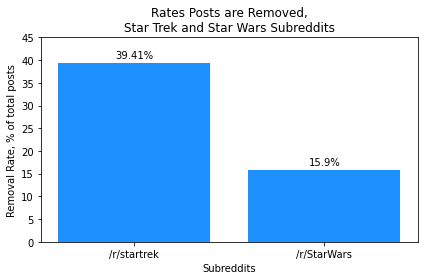

In [27]:
removal_rates = {
    'Star Trek': round((counts[0]/len(df[df["subreddit_name"] == "startrek"]))*100, 2),
    'Star Wars': round((counts[1]/len(df[df["subreddit_name"] == "starwars"]))*100, 2)
}
plt.title('Rates Posts are Removed,\nStar Trek and Star Wars Subreddits')
plt.xlabel('Subreddits')
plt.ylabel('Removal Rate, % of total posts')

plt.ylim(0, 45)
plt.bar(['/r/startrek', '/r/StarWars'], removal_rates.values(), color = 'dodgerblue')

plt.text(0, removal_rates['Star Trek']+1, str(removal_rates['Star Trek'])+'%', ha = 'center')
plt.text(1, removal_rates['Star Wars']+1, str(removal_rates['Star Wars'])+'%', ha = 'center')

plt.tight_layout()
plt.savefig('images/removal_rates.png');

## "Neutral" Stop Words

I referenced NLP 1, Lesson 5.01 to find the list of English stopwords, taken from nltk.corpus, although further work led me to believe this is not the same list as the 'english' stopwords in sklearn.

From the nltk.corpus list, I eliminated verbs (because I wanted "isn't" it didn't seem appropriate to eliminate "is"), clearly negative or positive words (e.g. 'no'), and gendered pronouns to see what, if any patterns emerged among those words in the text. I've saved more details in another notebook if you'd like to see it, but as it consisted of copying and pasting, then parsing through the nltk.corpus list (pulled up with `print(sorted((stopwords).words('english')))`), it didn't seem a good use of space here.

In [29]:
neutral_stopwords = ['a', 'about', 'above', 'after', 'again', 'all', 'an', 'any', 'as', 'at', 'because', 'before', 'below',
                     'between', 'both', 'by', 'd', 'during', 'each', 'for', 'from',  'here',  'how', 'i', 'if', 'in', 'into', 'it', "it's", 'its', 'itself',
                     'll', 'm', 'ma', 'me','my', 'myself', 'now', 'o', 'of', 'once', 'other', 'our', 'ours', 'ourselves', 
                     'own', 're', 's',   'such', 't', 'than', 'that', "that'll", 'the', 'their',
                     'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 
                      've', 'we', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'with', 
                     'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves']

I referenced the NLP Lab 5.02 on EDA for help with getting the following code right.

## Removed Posts Versus Not Removed Post Titles - "Neutral" Stop Words

In [30]:
cvec = CountVectorizer(stop_words = neutral_stopwords)
cvec.fit(df['title'])
vectorized = cvec.transform(df['title'])
print('Vectorized shape:', vectorized.shape)
print('Vectorized type:', type(vectorized))
print('='*25)

vectorized = pd.DataFrame(vectorized.todense(), columns = cvec.get_feature_names_out())
print('Vectorized dataframe shape:', vectorized.shape)
print('Vectorized dataframe type:', type(vectorized))
print('='*25)

with_removed_vectorized = pd.concat([df['selftext'], df['subreddit_name'], vectorized], axis = 1)
print('Vectorized dataframe with text and subreddit labels, shape:', with_removed_vectorized.shape)
print(with_removed_vectorized.head(1))
print("="*25)

print('Number of removed posts in new dataframe:', len(with_removed_vectorized[with_removed_vectorized["selftext"] == "[removed]"]))
print('Sanity check. Number of removed posts from original dataframe:', len(df[df["selftext"] == "[removed]"]))

print('')
print('')
print('*'*25)
print('')
print('')
print('EXAMINING ALL POSTS')
print('')

top_10_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] =='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:10]['index'])
top_10_not_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] !='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

print(f'The following words appear in the top 10 most used words in removed posts but not in the top 10 words for not-removed posts {[word for word in top_10_removed if word not in top_10_not_removed]}')
print('='*25)

top_25_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] =='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:25]['index'])
top_25_not_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] !='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

print(f'The following words appear in the top 25 most used words in removed posts but not in the top 25 words for not-removed posts {[word for word in top_25_removed if word not in top_25_not_removed]}')
print('='*25)

top_50_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] =='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:50]['index'])
top_50_not_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] !='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:50]['index'])

print(f'The following words appear in the top 50 most used words in removed posts but not in the top 50 words for not-removed posts {[word for word in top_50_removed if word not in top_50_not_removed]}')

print('')
print('')
print('*'*25)
print('')
print('')
print('EXAMINING STARTREK POSTS')
print('')

top_10_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])
top_10_not_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])

print(f'The following words appear in the top 10 most used words in removed "startrek"\n posts but not in the top 10 words for not-removed "startrek" posts {[word for word in top_10_removed_st if word not in top_10_not_removed_st]}')
print('='*25)

top_25_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])
top_25_not_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])

print(f'The following words appear in the top 25 most used words in removed "startrek"\n posts but not in the top 25 words for not-removed "startrek" posts {[word for word in top_25_removed_st if word not in top_25_not_removed_st]}')
print('='*25)

top_50_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])
top_50_not_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])

print(f'The following words appear in the top 50 most used words in removed "startrek" posts but not in the top 50 words for not-removed "startrek" posts {[word for word in top_50_removed_st if word not in top_50_not_removed_st]}')

print('')
print('')
print('*'*25)
print('')
print('')
print('EXAMINING STARWARS POSTS')
print('')

top_10_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])
top_10_not_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])

print(f'The following words appear in the top 10 most used words in removed "StarWars"\n posts but not in the top 10 words for not-removed "StarWars" posts {[word for word in top_10_removed_sw if word not in top_10_not_removed_sw]}')
print('='*20)

top_25_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])
top_25_not_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])

print(f'The following words appear in the top 25 most used words in removed "StarWars"\n posts but not in the top 25 words for not-removed "StarWars" posts {[word for word in top_25_removed_sw if word not in top_25_not_removed_sw]}')
print('='*20)

top_50_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])
top_50_not_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])

print(f'The following words appear in the top 50 most used words in removed "StarWars" posts but not in the top 50 words for not-removed "StarWars" posts {[word for word in top_50_removed_sw if word not in top_50_not_removed_sw]}')


Vectorized shape: (6946, 7908)
Vectorized type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorized dataframe shape: (6946, 7908)
Vectorized dataframe type: <class 'pandas.core.frame.DataFrame'>
Vectorized dataframe with text and subreddit labels, shape: (6946, 7910)
    selftext subreddit_name  00  000  01  010  01x06  02  02png  03  ...  \
0  [removed]       startrek   0    0   0    0      0   0      0   0  ...   

   ليلة  مهذبة  نسخ  وليلة  एक  लचस  षक  ดท  ทางเข  าส  
0     0      0    0      0   0    0   0   0      0   0  

[1 rows x 7910 columns]
Number of removed posts in new dataframe: 1936
Sanity check. Number of removed posts from original dataframe: 1936


*************************


EXAMINING ALL POSTS

The following words appear in the top 10 most used words in removed posts but not in the top 10 words for not-removed posts ['picard']
The following words appear in the top 25 most used words in removed posts but not in the top 25 words for not-removed posts ['snw', 'so', 'spo

### NOTE: Examining Word Counts Across Posts with 'Neutral' Stopwords

I examined Top 10, 25, and 50 words across all posts, 'startrek'-specific posts, and 'starwars'-specific posts, regardless of whether or not they were 'removed', but found the lists not insightful when compared with the lists below, with 'english' stopwords removed. Again, I've saved the work if you'd like to see it, but for the sake of space decided not to include it here.

-----

## Removed Posts Versus Not Removed Post Titles - "english" Stopwords
Here I repeated the exploration of the differences between removed and not-removec posts, this time with the sklearn 'english' stopwords removed.

In [32]:
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(df['title'])
vectorized = cvec.transform(df['title'])
print('Vectorized shape:', vectorized.shape)
print('Vectorized type:', type(vectorized))
print('='*25)

vectorized = pd.DataFrame(vectorized.todense(), columns = cvec.get_feature_names_out())
print('Vectorized dataframe shape:', vectorized.shape)
print('Vectorized dataframe type:', type(vectorized))
print('='*25)

with_removed_vectorized = pd.concat([df['selftext'], df['subreddit_name'], vectorized], axis = 1)
print('Vectorized dataframe with text and subreddit labels, shape:', with_removed_vectorized.shape)
print(with_removed_vectorized.head(1))
print("="*25)

print('Number of removed posts in new dataframe:', len(with_removed_vectorized[with_removed_vectorized["selftext"] == "[removed]"]))
print('Sanity check. Number of removed posts from original dataframe:', len(df[df["selftext"] == "[removed]"]))

print('')
print('')
print('*'*25)
print('')
print('')
print('EXAMINING ALL POSTS')
print('')

top_10_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] =='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:10]['index'])
top_10_not_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] !='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

print(f'The following words appear in the top 10 most used words in removed posts but not in the top 10 words for not-removed posts {[word for word in top_10_removed if word not in top_10_not_removed]}')
print('='*25)

top_25_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] =='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:25]['index'])
top_25_not_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] !='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

print(f'The following words appear in the top 25 most used words in removed posts but not in the top 25 words for not-removed posts {[word for word in top_25_removed if word not in top_25_not_removed]}')
print('='*25)

top_50_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] =='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:50]['index'])
top_50_not_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] !='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:50]['index'])

print(f'The following words appear in the top 50 most used words in removed posts but not in the top 50 words for not-removed posts {[word for word in top_50_removed if word not in top_50_not_removed]}')

print('')
print('')
print('*'*25)
print('')
print('')
print('EXAMINING STARTREK POSTS')
print('')

top_10_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])
top_10_not_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])

print(f'The following words appear in the top 10 most used words in removed "startrek"\n posts but not in the top 10 words for not-removed "startrek" posts {[word for word in top_10_removed_st if word not in top_10_not_removed_st]}')
print('='*25)

top_25_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])
top_25_not_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])

print(f'The following words appear in the top 25 most used words in removed "startrek"\n posts but not in the top 25 words for not-removed "startrek" posts {[word for word in top_25_removed_st if word not in top_25_not_removed_st]}')
print('='*25)

top_50_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])
top_50_not_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])

print(f'The following words appear in the top 50 most used words in removed "startrek" posts but not in the top 50 words for not-removed "startrek" posts {[word for word in top_50_removed_st if word not in top_50_not_removed_st]}')

print('')
print('')
print('*'*25)
print('')
print('')
print('EXAMINING STARWARS POSTS')
print('')

top_10_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])
top_10_not_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])

print(f'The following words appear in the top 10 most used words in removed "StarWars"\n posts but not in the top 10 words for not-removed "StarWars" posts {[word for word in top_10_removed_sw if word not in top_10_not_removed_sw]}')
print('='*20)

top_25_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])
top_25_not_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])

print(f'The following words appear in the top 25 most used words in removed "StarWars"\n posts but not in the top 25 words for not-removed "StarWars" posts {[word for word in top_25_removed_sw if word not in top_25_not_removed_sw]}')
print('='*20)

top_50_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])
top_50_not_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])

print(f'The following words appear in the top 50 most used words in removed "StarWars" posts but not in the top 50 words for not-removed "StarWars" posts {[word for word in top_50_removed_sw if word not in top_50_not_removed_sw]}')


Vectorized shape: (6946, 7719)
Vectorized type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorized dataframe shape: (6946, 7719)
Vectorized dataframe type: <class 'pandas.core.frame.DataFrame'>
Vectorized dataframe with text and subreddit labels, shape: (6946, 7721)
    selftext subreddit_name  00  000  01  010  01x06  02  02png  03  ...  \
0  [removed]       startrek   0    0   0    0      0   0      0   0  ...   

   ليلة  مهذبة  نسخ  وليلة  एक  लचस  षक  ดท  ทางเข  าส  
0     0      0    0      0   0    0   0   0      0   0  

[1 rows x 7721 columns]
Number of removed posts in new dataframe: 1936
Sanity check. Number of removed posts from original dataframe: 1936


*************************


EXAMINING ALL POSTS

The following words appear in the top 10 most used words in removed posts but not in the top 10 words for not-removed posts ['strange', 'worlds']
The following words appear in the top 25 most used words in removed posts but not in the top 25 words for not-removed posts ['quest

# Top Words Across Title and Self-Text -- 'english' Stopwords Removed

At this point, I looked at the top words for all the words in the post, both title and 'selftext' (the post body). Again, I did this because I found a large percentage of Star Wars posts actually had no text in the body, so I'm considering the titles an important part of the communication in /r/StarWars, in particular, and so am including all titles, for parity.

While it was interesting to look at these lists, in particular to see which characters and properties are being discussed most frequently, I had no concrete takeaways.

Instead, I tried using a set of the 3 top 50 word lists combined to make my modeling harder by pulling out the most frequently used proper names and specific show references. However, that didn't seem hard enough, so I created a similar set from the top 150 words (all posts, Star Trek, Star Wars) and used that, combined with scikit-learn's 'english' stopwords to make the modeling harder (in notebook 3)

In [38]:
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(df['all_words'])
vectorized = cvec.transform(df['all_words'])
print('Vectorized shape:', vectorized.shape)
print('Vectorized type:', type(vectorized))
print('='*25)

vectorized = pd.DataFrame(vectorized.todense(), columns = cvec.get_feature_names_out())
print('Vectorized dataframe shape:', vectorized.shape)
print('Vectorized dataframe type:', type(vectorized))
print('='*25)

vectorized = pd.concat([df['selftext'], df['subreddit_name'], vectorized], axis = 1)
print('Vectorized dataframe with text and subreddit labels, shape:', vectorized.shape)
print("="*25)

print('Number of removed posts in new dataframe:', len(vectorized[vectorized["selftext"] == "[removed]"]))
print('Sanity check. Number of removed posts from original dataframe:', len(df[df["selftext"] == "[removed]"]))

print('')
print('')
print('*'*25)
print('')
print('')
print('TOP WORDS')
print('')
print('')
print('='*25)
print('')
print('')

top_10_all = list(pd.Series(vectorized.drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

top_25_all = list(pd.Series(vectorized.drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

top_50_all = list(pd.Series(vectorized.drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:50]['index'])

top_10_all_st = list(pd.Series(vectorized[vectorized['subreddit_name'] == 'startrek'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

top_25_all_st = list(pd.Series(vectorized[vectorized['subreddit_name'] == 'startrek'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

top_50_all_st = list(pd.Series(vectorized[vectorized['subreddit_name'] == 'startrek'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:50]['index'])

top_10_all_sw = list(pd.Series(vectorized[vectorized['subreddit_name'] == 'starwars'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

top_25_all_sw = list(pd.Series(vectorized[vectorized['subreddit_name'] == 'starwars'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

top_50_all_sw = list(pd.Series(vectorized[with_removed_vectorized['subreddit_name'] == 'starwars'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:50]['index'])


print('Top 10, all posts:', top_10_all)
print('='*20)
print('Top 25, all posts:', top_25_all)
print('='*20)
print('Top 50, all posts:', top_50_all)
print('='*25)
print('')

print('Top 10, all Star Trek posts:', top_10_all_st)
print('='*20)
print('Top 25, all Star Trek posts:', top_25_all_st)
print('='*20)
print('Top 50, all Star Trek posts:', top_50_all_st)
print('='*25)
print('')

print('Top 10, all Star Wars posts:', top_10_all_sw)
print('='*20)
print('Top 25, all Star Wars posts:', top_25_all_sw)
print('='*20)
print('Top 50, all Star Wars posts:', top_50_all_sw)

#to have a dataframe to work from for below
all_words = vectorized.drop(columns = 'selftext')
all_words.head()

Vectorized shape: (6946, 19106)
Vectorized type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorized dataframe shape: (6946, 19106)
Vectorized dataframe type: <class 'pandas.core.frame.DataFrame'>
Vectorized dataframe with text and subreddit labels, shape: (6946, 19108)
Number of removed posts in new dataframe: 1936
Sanity check. Number of removed posts from original dataframe: 1936


*************************


TOP WORDS




Top 10, all posts: ['star', 'trek', 'like', 'episode', 'just', 'obi', 'wan', 'new', 'wars', 'season']
Top 25, all posts: ['star', 'trek', 'like', 'episode', 'just', 'obi', 'wan', 'new', 'wars', 'season', 'vader', 'picard', 'kenobi', 'think', 'time', 'know', 'series', 'did', 'really', 've', 'don', 'anakin', 'people', 'does', 'jedi']
Top 50, all posts: ['star', 'trek', 'like', 'episode', 'just', 'obi', 'wan', 'new', 'wars', 'season', 'vader', 'picard', 'kenobi', 'think', 'time', 'know', 'series', 'did', 'really', 've', 'don', 'anakin', 'people', 'does', 'jedi', 'good',

,subreddit_name,00,000,001,006225_8c6a1dd3,01,010,01414tqwn0t0,01x06,02,...,ليلة,مهذبة,نسخ,وليلة,एक,लचस,षक,ดท,ทางเข,าส
0,startrek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,startrek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,startrek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,startrek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,startrek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[This stackoverflow answer](https://stackoverflow.com/a/52461208) showed me how to set the xtick label rotation in a subplot.

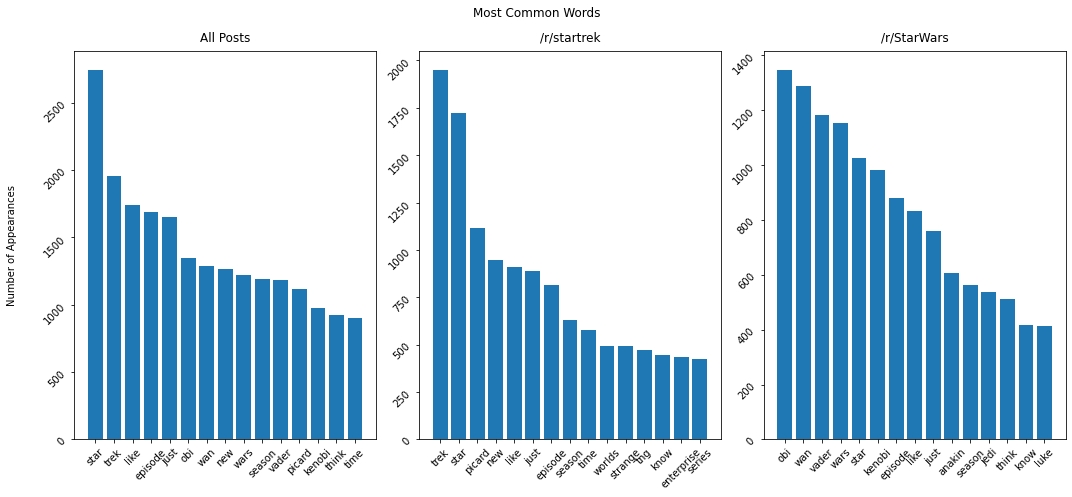

In [54]:
allkeys = all_words.drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).keys().tolist()
allvalues = all_words.drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).tolist()

stkeys = all_words[all_words["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).keys().tolist()
stvalues = all_words[all_words["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).tolist()

swkeys = all_words[all_words["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).keys().tolist()
swvalues = all_words[all_words["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).tolist()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,7)) #not setting sharey the same because the number of each is a different scale

fig.suptitle('Most Common Words')

ax1.bar(allkeys, allvalues)
ax1.tick_params(rotation = 45)
ax1.set_title('All Posts', pad = 10)
ax1.set_ylabel('Number of Appearances', labelpad = 25)

ax2.bar(stkeys, stvalues)
ax2.tick_params(rotation = 45)
ax2.set_title('/r/startrek', pad = 10)

ax3.bar(swkeys, swvalues)
ax3.tick_params(rotation = 45)
ax3.set_title('/r/StarWars', pad = 10)

plt.tight_layout()
plt.savefig('images/commonwords1.png');

### Developing Additional Stopwords to Make Modeling More Challenging

In [53]:
top_150 = all_words.drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(150).keys().tolist()
print('Top 150 words, all posts', top_150)
print(' ')
top_150_st = all_words[all_words["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(150).keys().tolist()
print('Top 150 words, Star Trek subreddit', top_150_st)
print(' ')
top_150_sw = all_words[all_words["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(150).keys().tolist()
print('Top 150 words, Star Wars subreddit', top_150_sw)
print('')

combined_top_set_150 = set(top_150+top_150_st+top_150_sw)
print('Set of words that appear in these three top 150s, alphabetical order', sorted(combined_top_set_150))

Top 150 words, all posts ['star', 'trek', 'like', 'episode', 'just', 'obi', 'wan', 'new', 'wars', 'season', 'vader', 'picard', 'kenobi', 'think', 'time', 'know', 'series', 'did', 'really', 've', 'don', 'anakin', 'people', 'does', 'jedi', 'good', 'worlds', 'strange', 'watch', 'way', 'tng', 'character', 'amp', 'love', 'force', 'make', 'enterprise', 'watching', 'episodes', 'luke', 'want', 'snw', 'feel', 'best', 'borg', 'order', 'story', 'ship', 'didn', 'years', 'got', 'darth', 'https', 'characters', 'shows', 'seen', 'great', 'going', 'discovery', 'lot', 'say', 'end', 'movies', 'com', 'movie', 'things', 'scene', 'clone', 'thought', 'better', 'old', 'question', 'tos', 'crew', 'captain', 'ds9', 'thing', 'life', 'universe', 'actually', 'fan', 'spoilers', 'canon', 'leia', 'hope', 'timeline', 'watched', 'doesn', 'point', 'spock', 'maybe', 'right', 'voyager', 'reva', 'space', 'original', 'use', 'future', 'disney', 'look', 'little', 'bad', 'tv', 'long', 'finale', 'let', 'federation', 'different',

In [44]:
expanded_proper_names = sorted(['seven', 'clone', 'warp', 'borg', 'trilogy', 'contact', 'anakin', 'paramount', 'leia',\
                         'kirk', 'wan', 'jedi', 'kenobi', 'snw', 'wars', 'vader', 'order', 'skywalker', 'klingon', 'starfleet',\
                         'ds9', 'captain', 'maul', 'luke', 'obi', 'rebels', 'data', 'voyager', 'st', 'discovery', 'federation',\
                         'pike', 'picard', 'mandalorian', 'klingons', 'star', 'tng', 'reva', 'strange', 'disney', 'worf',\
                         'riker', 'empire', 'jurati', 'palpatine', 'yoda', 'force', 'darth', 'republic', 'lightsaber', 'sith',\
                         'spock', 'boba', 'fett', 'inquisitor', 'trek', 'enterprise', 'tos', 'padme'])

print(expanded_proper_names)

expanded_stopwords = text.ENGLISH_STOP_WORDS.union(expanded_proper_names)

['anakin', 'boba', 'borg', 'captain', 'clone', 'contact', 'darth', 'data', 'discovery', 'disney', 'ds9', 'empire', 'enterprise', 'federation', 'fett', 'force', 'inquisitor', 'jedi', 'jurati', 'kenobi', 'kirk', 'klingon', 'klingons', 'leia', 'lightsaber', 'luke', 'mandalorian', 'maul', 'obi', 'order', 'padme', 'palpatine', 'paramount', 'picard', 'pike', 'rebels', 'republic', 'reva', 'riker', 'seven', 'sith', 'skywalker', 'snw', 'spock', 'st', 'star', 'starfleet', 'strange', 'tng', 'tos', 'trek', 'trilogy', 'vader', 'voyager', 'wan', 'warp', 'wars', 'worf', 'yoda']


# Exploring Post Length and Number of Words In Non-Removed or Deleted 'selftext' Posts

In this case, I looked at the bodies of posts ('selftext'), with the blank ones removed. The lengths of titles aren't as variable. The downside to this is we don't have as many Star Wars posts with text in the bodies, but I decided it was worth the tradeoff.

There are a lot of blank submissions. There are 6 '[deleted]' submissions, as well. '[deleted]' means that [the user deleted the post](https://www.reddit.com/r/help/comments/h92oqg/what_does_deleted_mean/).

For the purposes of examining word counts in these submissions, I've removed the empty and '[deleted]' submissions.

In [46]:
no_removed_or_deleted = df[(df['selftext'] != '[removed]') & (df['selftext'] != '[deleted]')]
print(no_removed_or_deleted['selftext'].value_counts()[:3])
print(no_removed_or_deleted.shape)
no_removed_or_deleted.head(2)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         2359
Anyone know where to get cool star wars phone wallpapers?                                                                                                                                                                                                                                                                                                 

,created_utc,selftext,subreddit_name,title,all_words,submission_length,title_length,submission_word_count,title_word_count,no_selftext,avg_word_length
1394,1656243979,,startrek,I’m beaming and I had to share - Sir Patrick Stewart answered my fan question on stage! An unforgettable moment for me.,I’m beaming and I had to share - Sir Patrick Stewart answered my fan question on stage! An unforgettable moment for me.,0.0,119.0,0.0,22.0,1.0,4.272727
1395,1656242414,,startrek,"America and the Star Trek Universe. Roe Vs Wade, LGBTQIA Rights, Racism.","America and the Star Trek Universe. Roe Vs Wade, LGBTQIA Rights, Racism.",0.0,72.0,0.0,12.0,1.0,4.750000


In [47]:
print(f'Submission length (characters) mean by subreddit is {no_removed_or_deleted.groupby(["subreddit_name"])["submission_length"].mean()}')
print(f'Submission length (characters median by subreddit is {no_removed_or_deleted.groupby(["subreddit_name"])["submission_length"].median()}')

Submission length (characters) mean by subreddit is subreddit_name
startrek    459.099486
starwars    243.629190
Name: submission_length, dtype: float64
Submission length (characters median by subreddit is subreddit_name
startrek    185.0
starwars      0.0
Name: submission_length, dtype: float64


I referred to the [matplotplib documentation](https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html) to create the below subplot. Very helpful. [This post](https://stackoverflow.com/a/15858264) helped me see how to adjust the ylim for subplots. [This documentation](https://matplotlib.org/stable/gallery/text_labels_and_annotations/titles_demo.html) showed me how to shift the title up a little so it wouldn't be so close to the subplot labels.

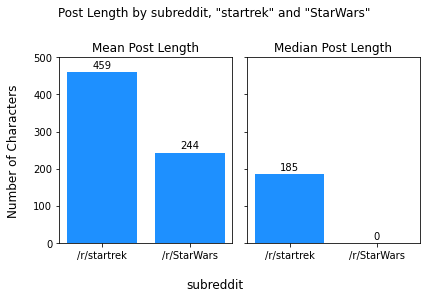

In [48]:
subm_mean_len = no_removed_or_deleted.groupby(["subreddit_name"])["submission_length"].mean().tolist()
subm_median_len = no_removed_or_deleted.groupby(["subreddit_name"])["submission_length"].median().tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
fig.suptitle('Post Length by subreddit, "startrek" and "StarWars"', y = 1)
fig.supylabel('Number of Characters')
fig.supxlabel('subreddit')

ax1.bar(['/r/startrek', '/r/StarWars'], [subm_mean_len[0], subm_mean_len[1]], color = 'dodgerblue')
ax1.set_title('Mean Post Length')
ax1.set_ylim(0,500)
ax1.text(0, subm_mean_len[0]+10, round(subm_mean_len[0]), ha = 'center')
ax1.text(1, subm_mean_len[1]+10, round(subm_mean_len[1]), ha = 'center')

ax2.bar(['/r/startrek', '/r/StarWars'], [subm_median_len[0], subm_median_len[1]], color = 'dodgerblue')
ax2.set_title('Median Post Length')
ax2.text(0, subm_median_len[0]+10, round(subm_median_len[0]), ha = 'center')
ax2.text(1, subm_median_len[1]+10, round(subm_median_len[1]), ha = 'center')

plt.tight_layout()
plt.savefig('images/post_length.png');

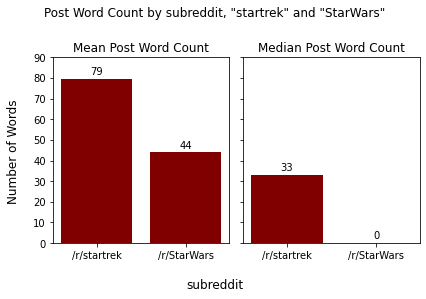

In [49]:
subm_word_count_mean = no_removed_or_deleted.groupby(["subreddit_name"])["submission_word_count"].mean().tolist()
subm_word_count_median = no_removed_or_deleted.groupby(["subreddit_name"])["submission_word_count"].median().tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
fig.suptitle('Post Word Count by subreddit, "startrek" and "StarWars"', y = 1)
fig.supylabel('Number of Words')
fig.supxlabel('subreddit')

ax1.bar(['/r/startrek', '/r/StarWars'], [subm_word_count_mean[0], subm_word_count_mean[1]], color = 'maroon')
ax1.set_title('Mean Post Word Count')
ax1.set_ylim(0,90)
ax1.text(0, subm_word_count_mean[0]+2, round(subm_word_count_mean[0]), ha = 'center')
ax1.text(1, subm_word_count_mean[1]+2, round(subm_word_count_mean[1]), ha = 'center')

ax2.bar(['/r/startrek', '/r/StarWars'], [subm_word_count_median[0], subm_word_count_median[1]], color = 'maroon')
ax2.set_title('Median Post Word Count')
ax2.text(0, subm_word_count_median[0]+2, round(subm_word_count_median[0]), ha = 'center')
ax2.text(1, subm_word_count_median[1]+2, round(subm_word_count_median[1]), ha = 'center')

plt.tight_layout()
plt.savefig('images/post_word_count.png');

-----

# Exploring Word Length in Posts, Both Titles and Bodies ('selftext')

I wanted to see if there was a difference in the length of the words used in each subreddit. I returned to using all the text available, both bodies ('selftext') and titles because of the prevalance of body free /r/StarWars posts. As it turns out, /r/startrek has both longer mean and median word lengths. 

A point for further future exploration would be to look at only bodies of posts: do people use longer words in bodies regardless of subreddit, thus skewing the Star Trek posts because they have more posts with bodies in them?

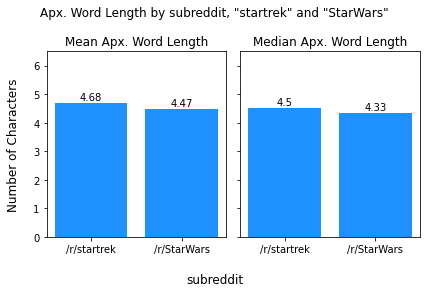

In [51]:
mean_word_length = df.groupby('subreddit_name')['avg_word_length'].mean().tolist()
median_word_length = df.groupby('subreddit_name')['avg_word_length'].median().tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
fig.suptitle('Apx. Word Length by subreddit, "startrek" and "StarWars"')
fig.supylabel('Number of Characters')
fig.supxlabel('subreddit')

ax1.bar(['/r/startrek', '/r/StarWars'], [mean_word_length[0], mean_word_length[1]], color = 'dodgerblue')
ax1.set_title('Mean Apx. Word Length')
ax1.set_ylim(0,6.5)
ax1.text(0, mean_word_length[0]+.1, round(mean_word_length[0], 2), ha = 'center')
ax1.text(1, mean_word_length[1]+.1, round(mean_word_length[1], 2), ha = 'center')

ax2.bar(['/r/startrek', '/r/StarWars'], [median_word_length[0], median_word_length[1]], color = 'dodgerblue')
ax2.set_title('Median Apx. Word Length')
ax2.text(0, median_word_length[0]+.1, round(median_word_length[0], 2), ha = 'center')
ax2.text(1, median_word_length[1]+.1, round(median_word_length[1], 2), ha = 'center')

plt.tight_layout()
plt.savefig('images/word_lengths.png');

-----

In [28]:
no_remov_del_subm.head()

,created_utc,selftext,subreddit_name,title,submission_length,submission_word_count,title_length,title_word_count
1394,1656243979,,startrek,I’m beaming and I had to share - Sir Patrick Stewart answered my fan question on stage! An unforgettable moment for me.,0,0,119,22
1395,1656242414,,startrek,"America and the Star Trek Universe. Roe Vs Wade, LGBTQIA Rights, Racism.",0,0,72,12
1396,1656224204,,startrek,Analysis: Star Trek: The Next Generation’ Guest Stars Most Likely To Appear In ‘Picard’ Season 3,0,0,96,16
1397,1656207850,,startrek,"One of the first occasions in which the word ""hell"" was used as profanity on television.",0,0,88,16
1398,1656195635,,startrek,Is A TOS Reboot Coming Soon?,0,0,28,6


In [29]:
all_blanks_and_text = no_remov_del_subm.copy()
all_blanks_and_text['all_words']= no_remov_del_subm['selftext']+' '+ no_remov_del_subm['title']
all_blanks_and_text = all_blanks_and_text[['subreddit_name', 'all_words']]
print('Head for new dataframe:\n', all_blanks_and_text.head(1))
print('')
print('Shape for new dataframe', all_blanks_and_text.shape)
print(' ')

cvec = CountVectorizer(stop_words = 'english')
cvec.fit(all_blanks_and_text['all_words'])
vectorized = cvec.transform(all_blanks_and_text['all_words'])
print('Shape for vectorized',vectorized.shape)
print(' ')


vectorized = pd.DataFrame(vectorized.todense(), columns = cvec.get_feature_names_out())
print('Shape for vectorized dataframe:', vectorized.shape)
print('Confirming the type is dataframe', type(vectorized))
print('')
print('Checking the new dataframe head\n',vectorized.head())

Head for new dataframe:
      subreddit_name  \
1394       startrek   

                                                                                                                     all_words  
1394   I’m beaming and I had to share - Sir Patrick Stewart answered my fan question on stage! An unforgettable moment for me.  

Shape for new dataframe (5005, 2)
 
Shape for vectorized (5005, 17719)
 
Shape for vectorized dataframe: (5005, 17719)
Confirming the type is dataframe <class 'pandas.core.frame.DataFrame'>

Checking the new dataframe head
    00  000  001  006225_8c6a1dd3  01  010  01414tqwn0t0  01x06  02  021  ...  \
0   0    0    0                0   0    0             0      0   0    0  ...   
1   0    0    0                0   0    0             0      0   0    0  ...   
2   0    0    0                0   0    0             0      0   0    0  ...   
3   0    0    0                0   0    0             0      0   0    0  ...   
4   0    0    0                0   0    0    

Initially, I was getting too many rows. Reading [this](https://stackoverflow.com/a/55726005) made it clear it was because of residual indexes, so I reset the indexes. Initially, I got some weird additional columns, so I played with it


In [30]:
subreddit_names = pd.DataFrame()
subreddit_names['subreddit_name'] = all_blanks_and_text['subreddit_name']
subreddit_names = subreddit_names.reset_index()

all_words_df = pd.concat([subreddit_names, vectorized], axis = 1)
all_words_df = all_words_df.drop(columns = 'index')
print('Shape for dataframe after adding in "subreddit name":', all_words_df.shape)
print('Checking head of new dataframe:\n',all_words_df.head())
print(' ')
print('*'*25)
print('')

print(f'The top 10 words in all these posts are:\n{all_words_df.drop(columns = "subreddit_name").sum().sort_values(ascending = False)[:10]}')
print(f'The top 10 words in all Star Trek posts are:\n{all_words_df[all_words_df["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False)[:10]}')
print(f'The top 10 words in all Star Wars posts are:\n{all_words_df[all_words_df["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False)[:10]}')


Shape for dataframe after adding in "subreddit name": (5005, 17719)
Checking head of new dataframe:
   subreddit_name  00  000  001  006225_8c6a1dd3  01  010  01414tqwn0t0  01x06  \
0       startrek   0    0    0                0   0    0             0      0   
1       startrek   0    0    0                0   0    0             0      0   
2       startrek   0    0    0                0   0    0             0      0   
3       startrek   0    0    0                0   0    0             0      0   
4       startrek   0    0    0                0   0    0             0      0   

   02  ...  ليلة  مهذبة  نسخ  وليلة  एक  लचस  षक  ดท  ทางเข  าส  
0   0  ...     0      0    0      0   0    0   0   0      0   0  
1   0  ...     0      0    0      0   0    0   0   0      0   0  
2   0  ...     0      0    0      0   0    0   0   0      0   0  
3   0  ...     0      0    0      0   0    0   0   0      0   0  
4   0  ...     0      0    0      0   0    0   0   0      0   0  

[5 rows x 17719

# Assembling Additional Data for Modeling (Word and Character Counts, Average Word Length)

I likely won't use the average word length because it's closely correlated to the other two.

In [ ]:
quant_info = pd.concat()

# Exploring Word Counts in Non-Removed Submission Posts with Proper Names Removed

I used the dataframe that I developed that combines titles and text into a single column for analysis. Now, though, I'm going to remove proper names I found were used frequently by adding to the stopwords. I opted to look at the top 50 words from the dataframe as a whole, among /r/startrek elements, and among /r/StarWars elements. I created a set with these words and selected the proper names by hand. 

There are a few choices that were subjective:

This includes removing "star" (most frequent word), "trek", and "wars" because they appear so frequently and are from the titles of these franchises. Also: 'force' (The Force). I also removed 'strange' because it's in the title of 'strange new worlds', though I've left in 'new' and 'worlds', which is a debatable decision. I've left 'order' in (i.e. not included it in my new stop words), though that may be a reference to the 'Sith Order' in Star Wars. 'captain' is another word I've left, though it's worth noting that is a very 'Star Trek' word, as almost every episode/show/movie has a captain, which is not true of Star Wars.

This [stackoverflow answer](https://stackoverflow.com/a/24386751) showed me how to combine the 'english' stopwords with my proper name stopwords.

Ultimately, I'm glad to have done this analysis, but I don't find what's left particularly revelatory. In terms of learning about the subreddits from the perspective of the most commonly used words, it seems to me that there's more to be gleaned (and more fun to be had) by seeing which characters, shows, etc., that show up versus the fairly banal list of words (and even abbreviations) that appear in the words that appear at the top of the lists when the proper names are removed.

In [56]:
cvec = CountVectorizer(stop_words = expanded_stopwords)
cvec.fit(df['all_words'])
vectorized = cvec.transform(df['all_words'])
print('Vectorized shape:', vectorized.shape)
print('')

vectorized = pd.DataFrame(vectorized.todense(), columns = cvec.get_feature_names_out())
print('Vectorized dataframe shape',vectorized.shape)
print("Confirming its type is dataframe:", type(vectorized))
print("Head of vectorized dataframe:\n",vectorized.head(1))
print('')

subreddit_names = pd.DataFrame()
subreddit_names['subreddit_name'] = df['subreddit_name']
subreddit_names = subreddit_names.reset_index()

temp_df = pd.concat([subreddit_names, vectorized], axis = 1)
temp_df = temp_df.drop(columns = 'index')
print("Shape of dataframe with subbreddit names restored:", temp_df.shape)
print("Head of dataframe with subbreddit names restored:\n", temp_df.head(1))

print('')
print('*'*25)

print(f'The top 10 words in all these posts are:\n{temp_df.drop(columns = "subreddit_name").sum().sort_values(ascending = False)[:10]}')
print(f'The top 10 words in all Star Trek posts are:\n{temp_df[temp_df["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False)[:10]}')
print(f'The top 10 words in all Star Wars posts are:\n{temp_df[temp_df["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False)[:10]}')


Vectorized shape: (6946, 19047)

Vectorized dataframe shape (6946, 19047)
Confirming its type is dataframe: <class 'pandas.core.frame.DataFrame'>
Head of vectorized dataframe:
    00  000  001  006225_8c6a1dd3  01  010  01414tqwn0t0  01x06  02  021  ...  \
0   0    0    0                0   0    0             0      0   0    0  ...   

   ليلة  مهذبة  نسخ  وليلة  एक  लचस  षक  ดท  ทางเข  าส  
0     0      0    0      0   0    0   0   0      0   0  

[1 rows x 19047 columns]

Shape of dataframe with subbreddit names restored: (6946, 19047)
Head of dataframe with subbreddit names restored:
   subreddit_name  00  000  001  006225_8c6a1dd3  01  010  01414tqwn0t0  01x06  \
0       startrek   0    0    0                0   0    0             0      0   

   02  ...  ليلة  مهذبة  نسخ  وليلة  एक  लचस  षक  ดท  ทางเข  าส  
0   0  ...     0      0    0      0   0    0   0   0      0   0  

[1 rows x 19047 columns]

*************************
The top 10 words in all these posts are:
like       1738


In [59]:
top_50 = temp_df.drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(50).keys().tolist()
print('Top 50 words, all posts', top_50)
print(' ')
top_50_st = temp_df[temp_df["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(50).keys().tolist()
print('Top 50 words, Star Trek subreddit', top_50_st)
print(' ')
top_50_sw = temp_df[temp_df["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(50).keys().tolist()
print('Top 50 words, Star Wars subreddit', top_50_sw)
print('')

combined_top_set = set(top_50+top_50_st+top_50_sw)
print('Set of words that appear in these three top 50s, in alphabetical order', sorted(combined_top_set))

Top 50 words, all posts ['like', 'episode', 'just', 'new', 'season', 'think', 'time', 'know', 'series', 'did', 'really', 've', 'don', 'people', 'does', 'good', 'worlds', 'watch', 'way', 'character', 'love', 'amp', 'make', 'watching', 'episodes', 'want', 'feel', 'best', 'ship', 'story', 'didn', 'years', 'got', 'https', 'characters', 'shows', 'seen', 'great', 'going', 'lot', 'say', 'end', 'movies', 'com', 'movie', 'things', 'scene', 'thought', 'better', 'old']
 
Top 50 words, Star Trek subreddit ['new', 'like', 'just', 'episode', 'season', 'time', 'worlds', 'know', 'series', 'think', 've', 'really', 'don', 'did', 'ship', 'episodes', 'people', 'does', 'good', 'watch', 'love', 'crew', 'watching', 'way', 'https', 'years', 'best', 'amp', 'com', 'make', 'character', 'characters', 'timeline', 'seen', 'want', 'space', 'got', 'going', 'future', 'shows', 'feel', 'story', 'universe', 'great', 'didn', 'life', 'things', 'end', 'different', 'better']
 
Top 50 words, Star Wars subreddit ['episode', 'l

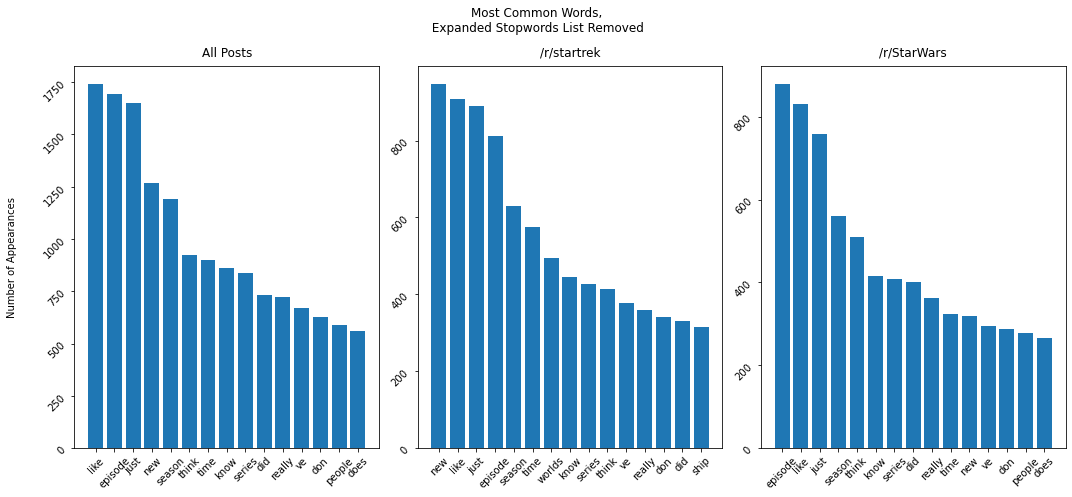

In [61]:
allkeys = temp_df.drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).keys().tolist()
allvalues = temp_df.drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).tolist()

stkeys = temp_df[temp_df["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).keys().tolist()
stvalues = temp_df[temp_df["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).tolist()

swkeys = temp_df[temp_df["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).keys().tolist()
swvalues = temp_df[temp_df["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).tolist()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,7)) #not setting sharey the same because the number of each is a different scale

fig.suptitle('Most Common Words,\n Expanded Stopwords List Removed')

ax1.bar(allkeys, allvalues)
ax1.tick_params(rotation = 45)
ax1.set_title('All Posts', pad = 10)
ax1.set_ylabel('Number of Appearances', labelpad = 25)

ax2.bar(stkeys, stvalues)
ax2.tick_params(rotation = 45)
ax2.set_title('/r/startrek', pad = 10)

ax3.bar(swkeys, swvalues)
ax3.tick_params(rotation = 45)
ax3.set_title('/r/StarWars', pad = 10)

plt.tight_layout()
plt.savefig('images/commonwords2.png');

-----

# Exporting the dataframe I want to work from for modeling

In [69]:
df.shape

(6946, 4)

In [62]:
if os.path.exists(f'data/cleaned_all_text{date.today()}.csv') == True:
    print('ERROR: This filename exists. Please choose a different filename. FILE WAS NOT SAVED.')
else:
    df.to_csv(f'data/cleaned_all_text{date.today()}.csv', index = False)

In [ ]:
# below is a line that can be uncommented and used to create a new dataframe on the same date.
# It's set to create cleaned_all_text{TODAY'SDATE}-1.

# all_blanks_and_text.to_csv(f'data/cleaned_all_text{date.today()}-1.csv', index = False)